# 03 Model Parameter Tuning
VGG19 has stood out in the model evaluation with the highest accuracy score. VGG19 will be fine tuned for the optimal set of parameters before trained with the full set of data.

Due to limitation in time and computational resources for such huge dataset in the Amazon Bin Image Dataset, automated hyperparameter tuning framework, such as Keras Tuner or GridSearch are not used for hyperparameter tuning. Instead, a manual tuning approach will be used in this project.

---
### 1. Import Libraries and variable setting


In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import keras
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D,Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Model

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import datetime
import gc
import cv2

For use when running the notebook on Google Colab. Comment these when running on local laptop

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/ColabData'
image_path = '/content/bin-images-224x224/bin-images-224x224'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For use when running the notebook on local laptop. Comment this line when running on Google Colab.

In [3]:
# drive_path = '../data'
# image_path = '../data/bin-images-224x224'

---
### 2. Load sample images/labels

In [4]:
# ! kaggle datasets download williamhyun/amazon-bin-image-dataset-536434-images-224x224

Dataset URL: https://www.kaggle.com/datasets/williamhyun/amazon-bin-image-dataset-536434-images-224x224
License(s): CC-BY-NC-SA-4.0
100% 3.50G/3.50G [03:09<00:00, 23.1MB/s]
100% 3.50G/3.50G [03:09<00:00, 19.8MB/s]


In [5]:
# !unzip /content/amazon-bin-image-dataset-536434-images-224x224.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/bin-images-224x224/bin-images-224x224/95055.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95056.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95057.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95058.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95059.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95060.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95061.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95062.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95063.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95064.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95065.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95066.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95067.jpg  
  inflating: 

load the prepared sampled images/labels from pickle

In [5]:
with open(f"{drive_path}/metadata_class_Q0_Q1_Q2_Q3_Q4_Q5_519a.pkl", 'rb') as file_images:
    metadata_class_df = pickle.load(file_images)
    file_images.close()

In [6]:
metadata_class_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361967 entries, 1 to 536433
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   bin_fcsku_data      361967 non-null  object
 1   expected_quantity   361967 non-null  int64 
 2   image_fname         361967 non-null  object
 3   sku_count           361967 non-null  int64 
 4   blurred_image_t100  361967 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 14.2+ MB


In [7]:
metadata_class_df['expected_quantity'].count()

361967

In [8]:
metadata_class_df.groupby('expected_quantity')[['blurred_image_t100']].value_counts()

expected_quantity  blurred_image_t100
0                  False                  5360
                   True                   4541
1                  False                 34523
                   True                   6824
2                  False                 67132
                   True                   9931
3                  False                 79327
                   True                  10931
4                  False                 71156
                   True                   9594
5                  False                 55092
                   True                   7556
Name: count, dtype: int64

In [9]:
def sampling_rows(group):
    # return group.sample(n=min(len(group), sample_per_class), random_state=42)
    return group.sample(n=min(len(group), 5000))

# using the groupby, together with sampling_rows function, to sample out "sample per class" images
sampled_metadata_df = metadata_class_df[metadata_class_df['blurred_image_t100']==False].groupby('expected_quantity', group_keys=False).apply(sampling_rows)

# to randomize the row index.
sampled_metadata_df = sampled_metadata_df.sample(frac=1, random_state=42).reset_index(drop=True)
sampled_metadata_df.head(5)

,bin_fcsku_data,expected_quantity,image_fname,sku_count,blurred_image_t100
0,{},0,268353.jpg,0,False
1,"{'0451470567': {'asin': '0451470567', 'height'...",4,204610.jpg,2,False
2,"{'B008DQXKZK': {'asin': 'B008DQXKZK', 'height'...",4,173442.jpg,2,False
3,"{'B0063PII32': {'asin': 'B0063PII32', 'height'...",5,504996.jpg,4,False
4,{},0,42312.jpg,0,False


In [4]:
sampled_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   bin_fcsku_data      30000 non-null  object
 1   expected_quantity   30000 non-null  int64 
 2   image_fname         30000 non-null  object
 3   sku_count           30000 non-null  int64 
 4   blurred_image_t100  30000 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 966.9+ KB


In [5]:
sampled_metadata_df.groupby('expected_quantity')[['blurred_image_t100']].value_counts()

expected_quantity  blurred_image_t100
0                  False                 5000
1                  False                 5000
2                  False                 5000
3                  False                 5000
4                  False                 5000
5                  False                 5000
Name: count, dtype: int64

In [6]:
# labels classes are based on the "expected_quantity"  0, 1, 2, ....
class_num = set(sampled_metadata_df['expected_quantity'])
nClasses = len(class_num)

# class_label_map will map the "qty count" to "label", countinous running number starting from 0
def class_labels(num):
        return { n:i for i,n in enumerate(num)}

class_label_map = class_labels(class_num)
class_label_map

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [7]:
images = []
labels = []
filename = []

def prep_image_for_ML_cv2(row):
    image = cv2.imread(image_path+'/'+row.image_fname)
    images.append(image)
    labels.append(np.array(class_label_map[row.expected_quantity]))
    filename.append(row.image_fname)

sampled_metadata_df.apply(prep_image_for_ML_cv2, axis='columns')

y_labels = np.empty( (len(labels),1), dtype=np.int8 )
for i, label_sample in enumerate(labels):
    y_labels[i] = label_sample

x_images = np.array( images, dtype=np.float32 ) / 255.0
# x_images = np.array( images, dtype=np.float32 )


In [8]:
len(x_images)

30000

In [9]:
x_images.shape

(30000, 224, 224, 3)

In [10]:
x_images[0]

array([[[0.5176471 , 0.8352941 , 0.98039216],
        [0.5019608 , 0.81960785, 0.9647059 ],
        [0.4627451 , 0.78039217, 0.9254902 ],
        ...,
        [0.40392157, 0.6431373 , 0.74509805],
        [0.4       , 0.6509804 , 0.74509805],
        [0.4       , 0.6509804 , 0.74509805]],

       [[0.5254902 , 0.84313726, 0.9882353 ],
        [0.50980395, 0.827451  , 0.972549  ],
        [0.46666667, 0.78431374, 0.92941177],
        ...,
        [0.40784314, 0.64705884, 0.7490196 ],
        [0.4       , 0.6509804 , 0.74509805],
        [0.4       , 0.6509804 , 0.74509805]],

       [[0.5411765 , 0.85490197, 1.        ],
        [0.52156866, 0.8352941 , 0.98039216],
        [0.4745098 , 0.7882353 , 0.93333334],
        ...,
        [0.4       , 0.6509804 , 0.7490196 ],
        [0.4       , 0.6509804 , 0.7490196 ],
        [0.39607844, 0.64705884, 0.74509805]],

       ...,

       [[0.5568628 , 0.85882354, 1.        ],
        [0.5411765 , 0.84313726, 0.99607843],
        [0.5058824 , 0

In [11]:
len(y_labels)

30000

In [12]:
y_labels.shape

(30000, 1)

In [13]:
y_labels[0:10]

array([[0],
       [4],
       [4],
       [5],
       [0],
       [1],
       [1],
       [1],
       [2],
       [3]], dtype=int8)

Export the sampled_metadata_df as the record for model_evaluation sampled data.

In [20]:
sampledata_class_pickle_file = open(f'{drive_path}/sampleddata_for03_class_Q0_Q1_Q2_Q3_Q4_Q5_519a.pkl','wb')
pickle.dump(sampled_metadata_df, sampledata_class_pickle_file)
sampledata_class_pickle_file.close()

visual checking (the first 10 images in the sampled dataset) to make sure the sampled images are good

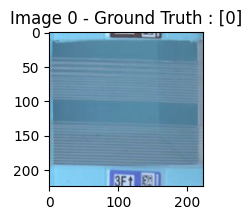

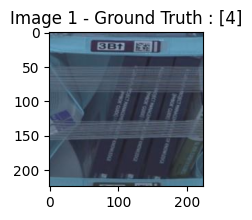

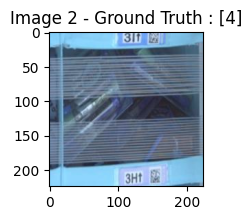

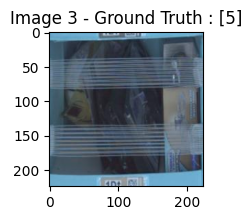

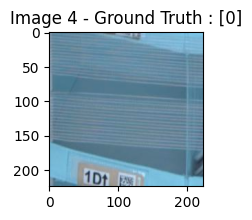

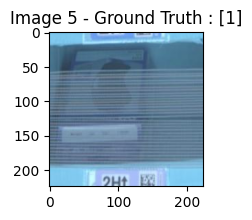

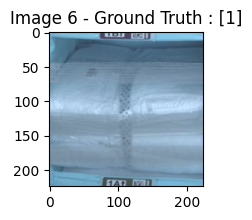

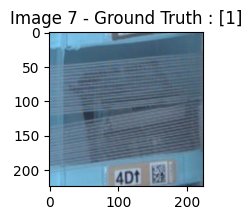

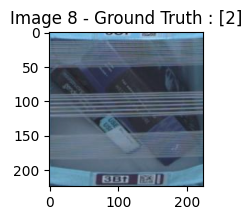

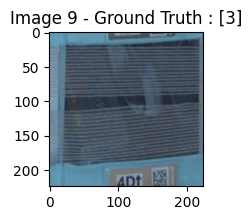

In [14]:
for i in range(10):
    plt.figure(figsize=[6,2])

    # plt.subplot(121)
    plt.imshow(x_images[i,:,:], cmap='gray')
    plt.title(f"Image {i} - Ground Truth : {format(y_labels[i])}")

---
### 3. Get Ready the sample images and labels

Train-Test-Split the data into training set and testing set, with Stratify set based on the labels in order to ensure balanced data.

In [15]:
train_images, test_images, train_labels, test_labels = train_test_split(x_images,
                                                                        y_labels,
                                                                        test_size = 0.2,
                                                                        stratify=y_labels,
                                                                        random_state=42)

In [16]:
train_images.shape

(24000, 224, 224, 3)

In [17]:
train_labels.shape

(24000, 1)

In [18]:
test_images.shape

(6000, 224, 224, 3)

In [19]:
test_labels.shape

(6000, 1)

one-hot-encoding to the train_labels and test_labels

In [20]:
train_labels_oh = to_categorical(train_labels)
test_labels_oh = to_categorical(test_labels)

In [21]:
train_labels_oh

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [22]:
test_labels_oh

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

Print training sample shape, test sample shape and total number of classes present from the sampled data set. There are 6 classes expected. Print two example image from training set and test set for visible verification.


Training data shape :  (24000, 224, 224, 3) (24000, 1)
Testing data shape :  (6000, 224, 224, 3) (6000, 1)
Total number of outputs :  6
Output classes :  [0 1 2 3 4 5]


Text(0.5, 1.0, 'Ground Truth : [1]')

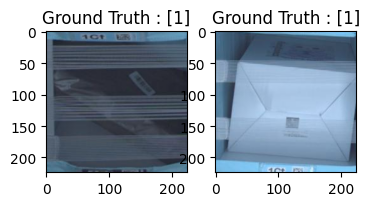

In [23]:
print('Training data shape : ', train_images.shape, train_labels.shape)

print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

plt.figure(figsize=[4,2])

# Display the second image in training data
plt.subplot(121)
plt.imshow(train_images[10,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[10]))

# # Display the second image in testing data
plt.subplot(122)
plt.imshow(test_images[50,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[50]))

In [24]:
# x_images and y_labels are no longer required. Del them to clear memory space.
del x_images
del y_labels
gc.collect() #force garbage collection to clear up unused memory, for subsequent run

28985

---
### 4. Model Parameter Tuning

Initialize `evaluate_result`, a dictionary to hold all the model evaluation result
Give a unique identifier in `train_remarks` for each model evaluation execution. The UID is used in exported pickle/keras model, and logs for tensorboard


In [25]:
evaluate_result = {}


In [26]:
def eval_model(model1, train_remarks, test_x, test_y, test_y_oh, fit_history, eval_result, num_classes):

  def plot_metric_curve(t_metric, v_metric, metric_n, title):
    plt.figure(figsize=(8, 6))

    # Generate line plot
    plt.plot(t_metric, label='Train'+metric_n)
    plt.plot(v_metric, label='Validation'+metric_n)

    plt.xlabel('Epoch')
    plt.ylabel(metric_n)
    plt.title(title+" "+metric_n+" Curve")
    plt.legend();

  # plot loss curve
  train_loss = fit_history.history['loss']
  value_loss = fit_history.history['val_loss']
  plot_metric_curve(train_loss, value_loss, "Loss", train_remarks)

  # plot accuracy curve
  train_accuracy = fit_history.history['accuracy']
  value_accuracy = fit_history.history['val_accuracy']
  plot_metric_curve(train_accuracy, value_accuracy, "Accuracy",train_remarks)


  # plot recall curve
  train_accuracy = fit_history.history['recall']
  value_accuracy = fit_history.history['val_recall']
  plot_metric_curve(train_accuracy, value_accuracy, "Recall",train_remarks)

  # confusion Matrix
  y_pred = model1.predict(test_x)
  y_pred_classes = np.argmax(y_pred, axis=-1)  # Convert probabilities to class labels
  # y_true = np.argmax(test_y, axis=-1)
  cm = confusion_matrix(test_y, y_pred_classes)

  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

  # metric evaluation
  eval_result[train_remarks] = {}
  eval_score = model1.evaluate(test_x, test_y_oh)
  eval_labels = model1.metrics_names

  eval_result[train_remarks][eval_labels[0]] = round(eval_score[0], 4)
  eval_result[train_remarks][eval_labels[1]] = round(eval_score[1], 4)

  def calculate_metrics(cm, class_index):
    TP = cm[class_index, class_index]  # Diagonal element for the specific class
    FP = np.sum(cm[:, class_index]) - TP
    FN = np.sum(cm[class_index, :]) - TP
    TN = cm.sum() - TP - FP - FN # Calculate True Negatives
    print(f"Class={class_index}|TP={TP}, FP={FP}, FN={FN}, TN={TN}")

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score, specificity, accuracy

  for class_ind in range(num_classes):
    precision, recall, f1_score, specificity, accuracy = calculate_metrics(cm, class_index=class_ind)
    eval_result[train_remarks][str(class_ind)+'_Precision'] = precision
    eval_result[train_remarks][str(class_ind)+'_Recall'] = recall
    eval_result[train_remarks][str(class_ind)+'_F1_Score'] = f1_score
    eval_result[train_remarks][str(class_ind)+'_Specificity'] = specificity
    eval_result[train_remarks][str(class_ind)+'_Accuracy'] = accuracy

  print(f"Metric evaluation for {train_remarks}>> \n{eval_result}")

Parameter tuning hp1: During model evaluation, the accuracy curve and loss curve were having slight oscilation (i.e. not smooth). Setting the learning rate to a smaller value `learning_rate=0.00001`.



80134624/80134624 [==============================] - 4s 0us/step
Epoch 1/15
750/750 [==============================] - 37s 42ms/step - loss: 1.7162 - accuracy: 0.2673 - recall: 0.0209 - val_loss: 1.5434 - val_accuracy: 0.3383 - val_recall: 0.0828
Epoch 2/15
750/750 [==============================] - 25s 33ms/step - loss: 1.5609 - accuracy: 0.3323 - recall: 0.0913 - val_loss: 1.4575 - val_accuracy: 0.3767 - val_recall: 0.1372
Epoch 3/15
750/750 [==============================] - 25s 33ms/step - loss: 1.5026 - accuracy: 0.3492 - recall: 0.1229 - val_loss: 1.4145 - val_accuracy: 0.3792 - val_recall: 0.1522
Epoch 4/15
750/750 [==============================] - 25s 33ms/step - loss: 1.4699 - accuracy: 0.3586 - recall: 0.1370 - val_loss: 1.3896 - val_accuracy: 0.3910 - val_recall: 0.1510
Epoch 5/15
750/750 [==============================] - 25s 33ms/step - loss: 1.4437 - accuracy: 0.3636 - recall: 0.1440 - val_loss: 1.3732 - val_accuracy: 0.4032 - val_recall: 0.1558
Epoch 6/15
750/750 [=====

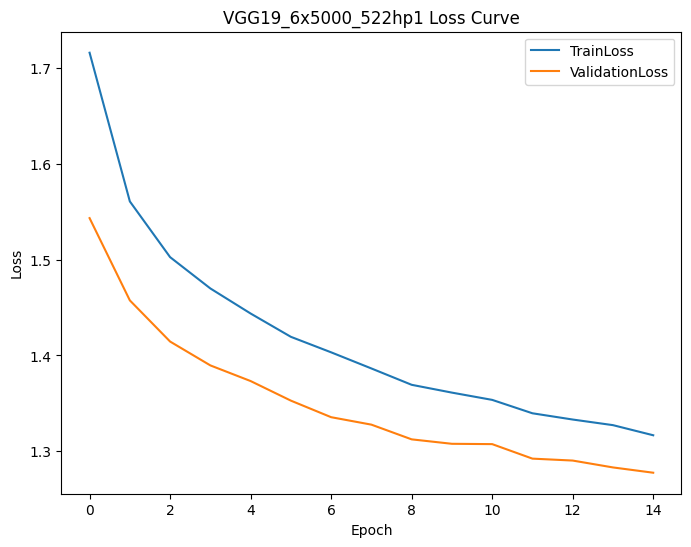

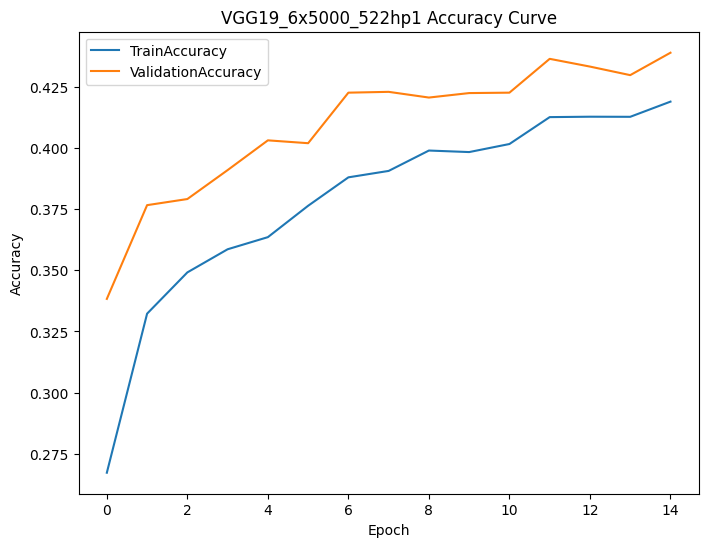

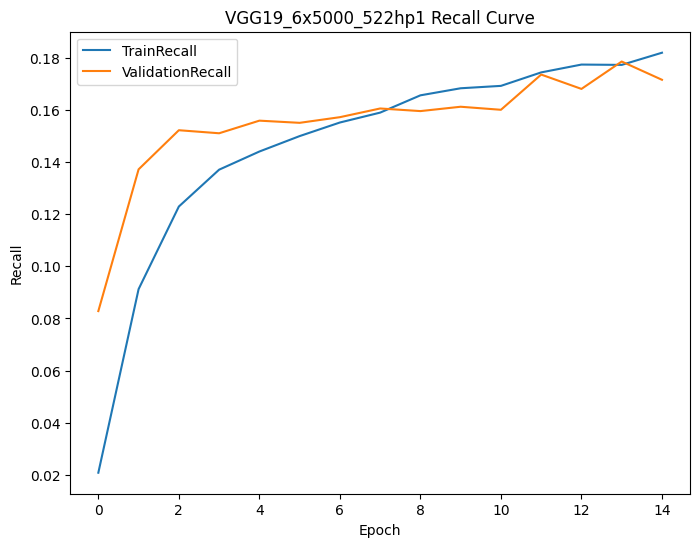

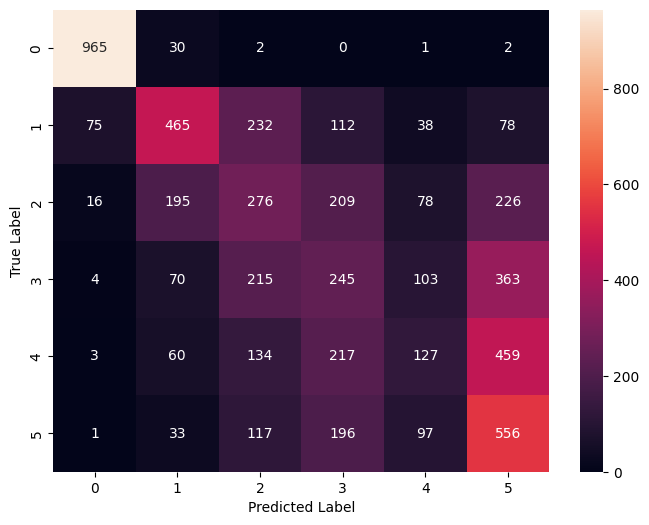

188/188 [==============================] - 5s 27ms/step - loss: 1.2775 - accuracy: 0.4390 - recall: 0.1715
Class=0|TP=965, FP=99, FN=35, TN=4901
Class=1|TP=465, FP=388, FN=535, TN=4612
Class=2|TP=276, FP=700, FN=724, TN=4300
Class=3|TP=245, FP=734, FN=755, TN=4266
Class=4|TP=127, FP=317, FN=873, TN=4683
Class=5|TP=556, FP=1128, FN=444, TN=3872
Metric evaluation for VGG19_6x5000_522hp1>> 
{'VGG19_6x5000_522hp1': {'loss': 1.2775, 'accuracy': 0.439, '0_Precision': 0.9069548872180451, '0_Recall': 0.965, '0_F1_Score': 0.935077519379845, '0_Specificity': 0.9802, '0_Accuracy': 0.9776666666666667, '1_Precision': 0.5451348182883939, '1_Recall': 0.465, '1_F1_Score': 0.5018888289260658, '1_Specificity': 0.9224, '1_Accuracy': 0.8461666666666666, '2_Precision': 0.2827868852459016, '2_Recall': 0.276, '2_F1_Score': 0.27935222672064774, '2_Specificity': 0.86, '2_Accuracy': 0.7626666666666667, '3_Precision': 0.25025536261491316, '3_Recall': 0.245, '3_F1_Score': 0.247599797877716, '3_Specificity': 0.853

In [30]:
param_remarks = "VGG19_6x5000_522hp1"

pre_trained_model = VGG19(include_top = False,
                                weights="imagenet",
                                input_shape=train_images.shape[1:])
pre_trained_model.trainable = False

x = pre_trained_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.55)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.55)(x)
predictions = Dense(nClasses, activation='softmax')(x)

model_VGG19 = Model(inputs=pre_trained_model.input, outputs=predictions)

# preparing the model fit - AdamW optimizer will be used for all model evaluation
opt = keras.optimizers.AdamW(learning_rate=0.00001)
model_VGG19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='recall')])

# preparing the model fit - initialize the TensorBoard
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"./logs/{timestamp}_{param_remarks}"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# preparing the model fit - EarlyStopping regularization setup to prevent unnecessary overrun
early_stop = EarlyStopping( monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          mode = 'auto')


history = model_VGG19.fit(train_images,
                        train_labels_oh,
                        batch_size=32,
                        epochs=15,
                        verbose=1,
                        validation_data=(test_images, test_labels_oh),
                        callbacks=[tensorboard_callback, early_stop])

eval_model(model_VGG19, param_remarks, test_images, test_labels, test_labels_oh, history, evaluate_result, nClasses)


Parameter tuning hp1 outcome: The accuracy curve and loss curve are smoother due to smaller learning rate, as a result the accuracy also dropped despite more epochs were executed compared to model evaluation. From the confusion matrix, the False Positive for label 1,2, and 4 has increase alot (i.e. drop in Recall for label 1,2  and 4), although improve in recall for label 5. On the other hand, False Negative for label 5 increased alot, which reason to be determined.

Parameter tuning hp2: Since there is not much improvement achieved in hp1, more weights in the pretrained-model lower level to be trained and adapted to the dataset. Therefore, in hp2, all the layers in the pre-trained model will be set to trainable. This is to allow the convolutional layers can also be trained to generalize the images, which may be very different compared to the ImageNet dataset.   

Epoch 1/20
188/188 [==============================] - 87s 344ms/step - loss: 1.6739 - accuracy: 0.2843 - recall: 0.0515 - val_loss: 1.3664 - val_accuracy: 0.4123 - val_recall: 0.1623
Epoch 2/20
188/188 [==============================] - 48s 257ms/step - loss: 1.4324 - accuracy: 0.3802 - recall: 0.1650 - val_loss: 1.2987 - val_accuracy: 0.4487 - val_recall: 0.1633
Epoch 3/20
188/188 [==============================] - 48s 257ms/step - loss: 1.3617 - accuracy: 0.4177 - recall: 0.2022 - val_loss: 1.2472 - val_accuracy: 0.4665 - val_recall: 0.2045
Epoch 4/20
188/188 [==============================] - 48s 257ms/step - loss: 1.3201 - accuracy: 0.4367 - recall: 0.2240 - val_loss: 1.2147 - val_accuracy: 0.4822 - val_recall: 0.2377
Epoch 5/20
188/188 [==============================] - 48s 257ms/step - loss: 1.2863 - accuracy: 0.4454 - recall: 0.2400 - val_loss: 1.1927 - val_accuracy: 0.4848 - val_recall: 0.2452
Epoch 6/20
188/188 [==============================] - 48s 258ms/step - loss: 1.2514 -

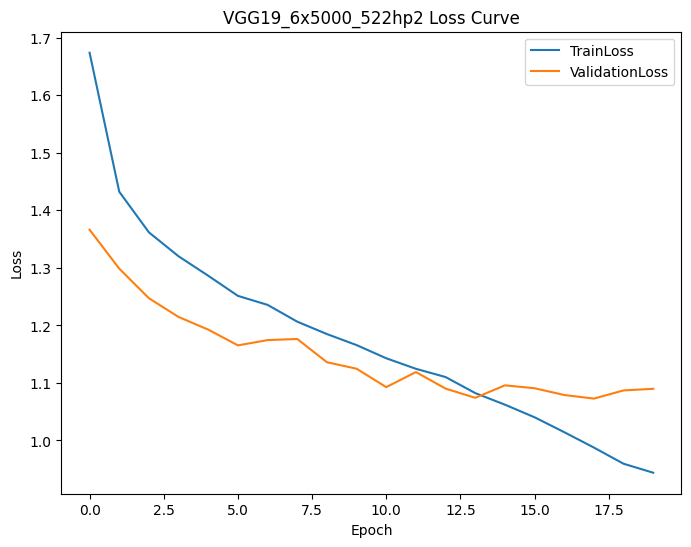

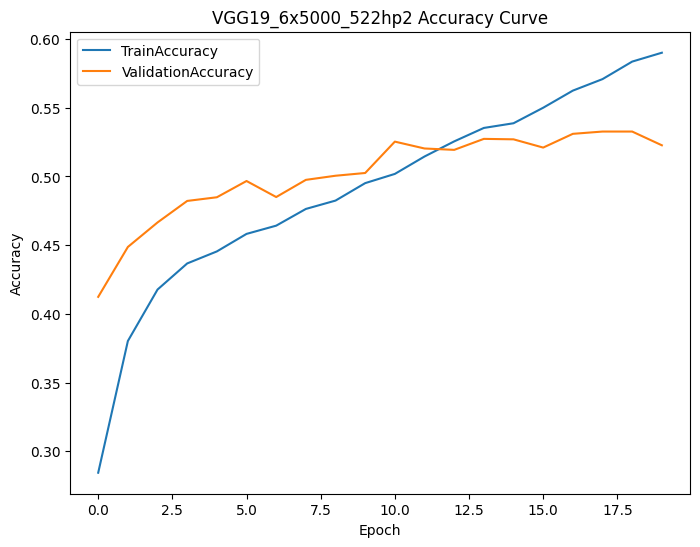

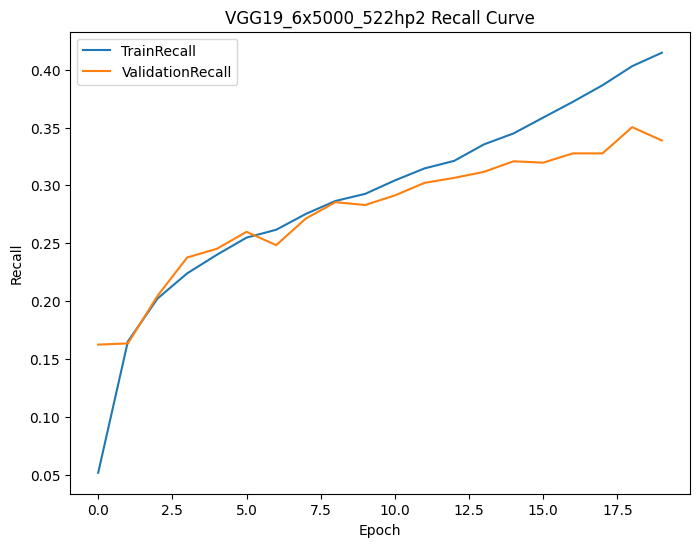

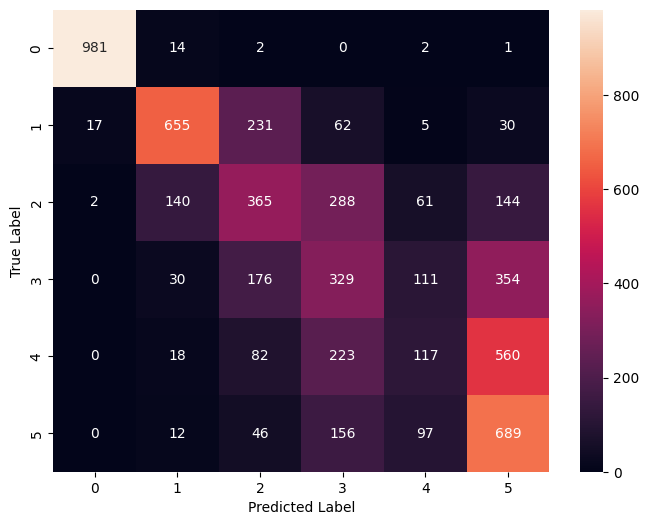

188/188 [==============================] - 5s 27ms/step - loss: 1.0898 - accuracy: 0.5227 - recall: 0.3388
Class=0|TP=981, FP=19, FN=19, TN=4981
Class=1|TP=655, FP=214, FN=345, TN=4786
Class=2|TP=365, FP=537, FN=635, TN=4463
Class=3|TP=329, FP=729, FN=671, TN=4271
Class=4|TP=117, FP=276, FN=883, TN=4724
Class=5|TP=689, FP=1089, FN=311, TN=3911
Metric evaluation for VGG19_6x5000_522hp2>> 
{'VGG19_6x5000_522hp2': {'loss': 1.0898, 'accuracy': 0.5227, '0_Precision': 0.981, '0_Recall': 0.981, '0_F1_Score': 0.9810000000000001, '0_Specificity': 0.9962, '0_Accuracy': 0.9936666666666667, '1_Precision': 0.7537399309551208, '1_Recall': 0.655, '1_F1_Score': 0.7009095773140718, '1_Specificity': 0.9572, '1_Accuracy': 0.9068333333333334, '2_Precision': 0.40465631929046564, '2_Recall': 0.365, '2_F1_Score': 0.38380651945320715, '2_Specificity': 0.8926, '2_Accuracy': 0.8046666666666666, '3_Precision': 0.31096408317580343, '3_Recall': 0.329, '3_F1_Score': 0.3197278911564626, '3_Specificity': 0.8542, '3_A

In [29]:
param_remarks2 = "VGG19_6x5000_522hp2"

pre_trained_model2 = VGG19(include_top = False,
                                weights="imagenet",
                                input_shape=train_images.shape[1:])
pre_trained_model2.trainable = False

for layer in pre_trained_model2.layers:
    layer.trainable = True

x = pre_trained_model2.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.55)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.55)(x)
predictions = Dense(nClasses, activation='softmax')(x)

model_VGG192 = Model(inputs=pre_trained_model2.input, outputs=predictions)

# preparing the model fit - AdamW optimizer will be used for all model evaluation
opt = keras.optimizers.AdamW(learning_rate=0.00001)
model_VGG192.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='recall')])

# preparing the model fit - initialize the TensorBoard
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"./logs/{timestamp}_{param_remarks2}"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# preparing the model fit - EarlyStopping regularization setup to prevent unnecessary overrun
early_stop = EarlyStopping( monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          mode = 'auto')


history2 = model_VGG192.fit(train_images,
                        train_labels_oh,
                        batch_size=128,
                        epochs=20,
                        verbose=1,
                        validation_data=(test_images, test_labels_oh),
                        callbacks=[tensorboard_callback, early_stop])

eval_model(model_VGG192, param_remarks2, test_images, test_labels, test_labels_oh, history2, evaluate_result, nClasses)

Parameter Tuning hp2 outcome: There is much improved in both the Accuracy and Recall! The Recall for individual label has also improved, except label 4. The same observation on False Positive for Label 5 still exist, although Recall for label 5 slight improved from 0.556 to 0.689.

In [31]:
del model_VGG192
del pre_trained_model2
del history2
gc.collect()

26584

Parameter Tuning hp3: Continue from hp2 where all layers will be set to trainable, the top layer Fully Connected network has also doubled the nodes in both layers, in order to allow more generalized details for classification to be trained.

Epoch 1/20
375/375 [==============================] - 75s 155ms/step - loss: 1.5322 - accuracy: 0.3360 - recall: 0.1318 - val_loss: 1.2842 - val_accuracy: 0.4308 - val_recall: 0.1818
Epoch 2/20
375/375 [==============================] - 50s 134ms/step - loss: 1.3231 - accuracy: 0.4211 - recall: 0.2071 - val_loss: 1.2084 - val_accuracy: 0.4707 - val_recall: 0.2305
Epoch 3/20
375/375 [==============================] - 50s 135ms/step - loss: 1.2655 - accuracy: 0.4450 - recall: 0.2320 - val_loss: 1.2184 - val_accuracy: 0.4467 - val_recall: 0.2615
Epoch 4/20
375/375 [==============================] - 50s 134ms/step - loss: 1.2154 - accuracy: 0.4647 - recall: 0.2554 - val_loss: 1.1542 - val_accuracy: 0.4815 - val_recall: 0.2688
Epoch 5/20
375/375 [==============================] - 50s 134ms/step - loss: 1.1783 - accuracy: 0.4835 - recall: 0.2760 - val_loss: 1.1375 - val_accuracy: 0.4897 - val_recall: 0.2733
Epoch 6/20
375/375 [==============================] - 50s 134ms/step - loss: 1.1500 -

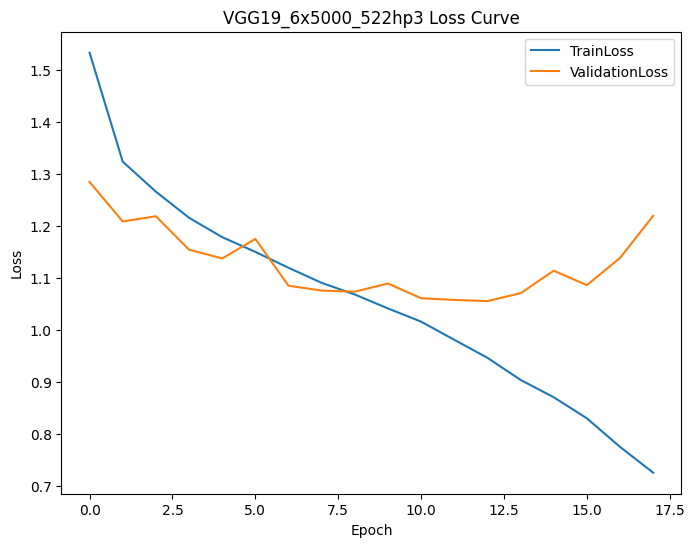

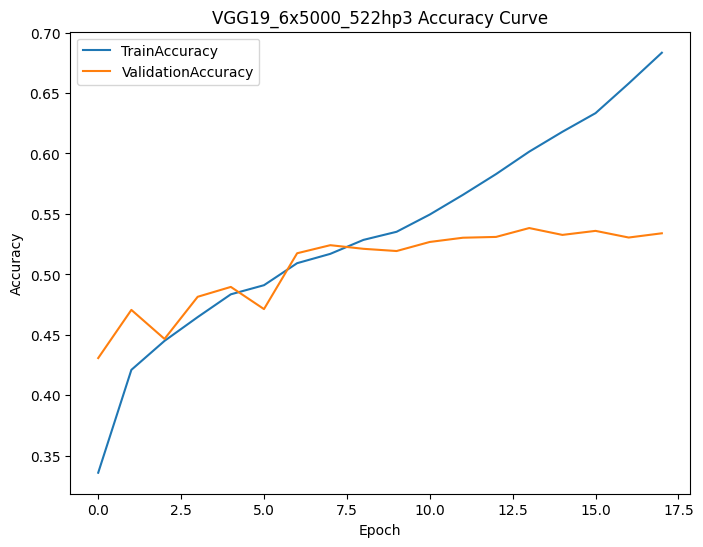

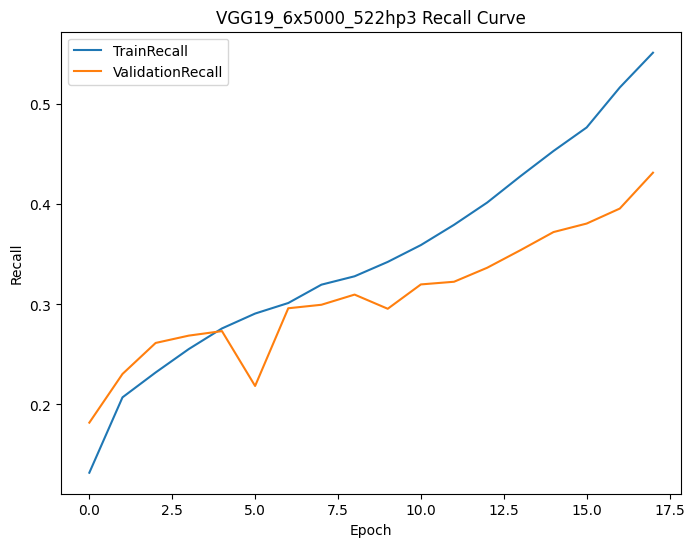

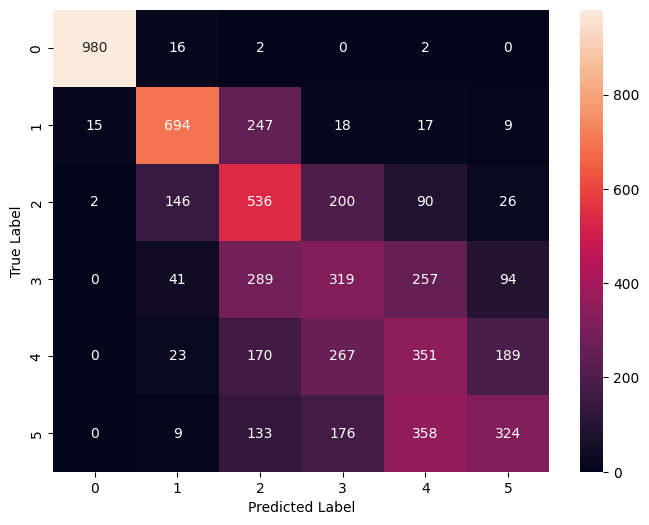

188/188 [==============================] - 5s 27ms/step - loss: 1.2193 - accuracy: 0.5340 - recall: 0.4317
Class=0|TP=980, FP=17, FN=20, TN=4983
Class=1|TP=694, FP=235, FN=306, TN=4765
Class=2|TP=536, FP=841, FN=464, TN=4159
Class=3|TP=319, FP=661, FN=681, TN=4339
Class=4|TP=351, FP=724, FN=649, TN=4276
Class=5|TP=324, FP=318, FN=676, TN=4682
Metric evaluation for VGG19_6x5000_522hp3>> 
{'VGG19_6x5000_522hp3': {'loss': 1.2193, 'accuracy': 0.534, '0_Precision': 0.9829488465396189, '0_Recall': 0.98, '0_F1_Score': 0.9814722083124687, '0_Specificity': 0.9966, '0_Accuracy': 0.9938333333333333, '1_Precision': 0.7470398277717977, '1_Recall': 0.694, '1_F1_Score': 0.7195438050803524, '1_Specificity': 0.953, '1_Accuracy': 0.9098333333333334, '2_Precision': 0.38925199709513436, '2_Recall': 0.536, '2_F1_Score': 0.4509886411442996, '2_Specificity': 0.8318, '2_Accuracy': 0.7825, '3_Precision': 0.32551020408163267, '3_Recall': 0.319, '3_F1_Score': 0.32222222222222224, '3_Specificity': 0.8678, '3_Accu

In [27]:
param_remarks3 = "VGG19_6x5000_522hp3"

pre_trained_model3 = VGG19(include_top = False,
                                weights="imagenet",
                                input_shape=train_images.shape[1:])
pre_trained_model3.trainable = False

for layer in pre_trained_model3.layers:
    layer.trainable = True

x = pre_trained_model3.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.55)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.55)(x)
predictions = Dense(nClasses, activation='softmax')(x)

model_VGG193 = Model(inputs=pre_trained_model3.input, outputs=predictions)

# preparing the model fit - AdamW optimizer will be used for all model evaluation
opt = keras.optimizers.AdamW(learning_rate=0.00001)
model_VGG193.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='recall')])

# preparing the model fit - initialize the TensorBoard
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"./logs/{timestamp}_{param_remarks3}"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# preparing the model fit - EarlyStopping regularization setup to prevent unnecessary overrun
early_stop = EarlyStopping( monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          mode = 'auto')


history3 = model_VGG193.fit(train_images,
                        train_labels_oh,
                        batch_size=64,
                        epochs=20,
                        verbose=1,
                        validation_data=(test_images, test_labels_oh),
                        callbacks=[tensorboard_callback, early_stop])

eval_model(model_VGG193, param_remarks3, test_images, test_labels, test_labels_oh, history3, evaluate_result, nClasses)

Parameter tuning hp3 outcome: The overall accuracy slight increase to 0.5340 (from 0.5227 in hp2), while the overall recall improved from 0.3388 to 0.4317. This can be observed from the confusion matrix, where the True Positive (along the diagonal) improved, and the "high clustering" of False Positive for Label 5 also no longer observed.

Parameter tuning hp4: Although the accuracy and recall has improved much in hp3, there is overfitting observed as the epoch progressed. While overfitting may be overcome in the final training with a much larger dataset, I am trying to use different optimizer which may help in overcoming overfitting and improve result. RMSprop optimizer will be used in hp4. RMSprop may mitigate the exploding gradient problem observed in hp3.

Epoch 1/20
375/375 [==============================] - 71s 152ms/step - loss: 98275612011003904.0000 - accuracy: 0.1653 - recall: 0.0724 - val_loss: 1.7919 - val_accuracy: 0.1667 - val_recall: 0.0000e+00
Epoch 2/20
375/375 [==============================] - 49s 132ms/step - loss: 22.3168 - accuracy: 0.1681 - recall: 0.0027 - val_loss: 1.7926 - val_accuracy: 0.1667 - val_recall: 0.0000e+00
Epoch 3/20
375/375 [==============================] - 50s 132ms/step - loss: 5.6276 - accuracy: 0.1665 - recall: 4.1667e-04 - val_loss: 1.7922 - val_accuracy: 0.1667 - val_recall: 0.0000e+00
Epoch 4/20
375/375 [==============================] - 49s 132ms/step - loss: 2.0944 - accuracy: 0.1636 - recall: 2.9167e-04 - val_loss: 1.7920 - val_accuracy: 0.1667 - val_recall: 0.0000e+00
Epoch 5/20
375/375 [==============================] - 49s 132ms/step - loss: 1.9160 - accuracy: 0.1641 - recall: 1.6667e-04 - val_loss: 1.7927 - val_accuracy: 0.1667 - val_recall: 0.0000e+00
Epoch 6/20
188/188 [================

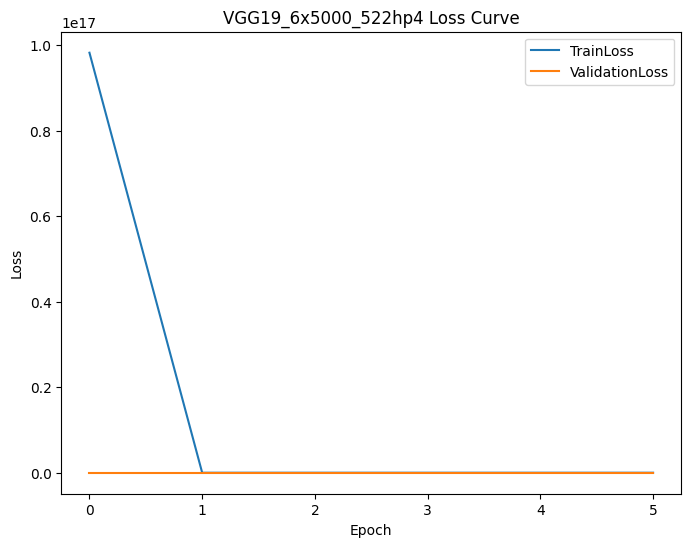

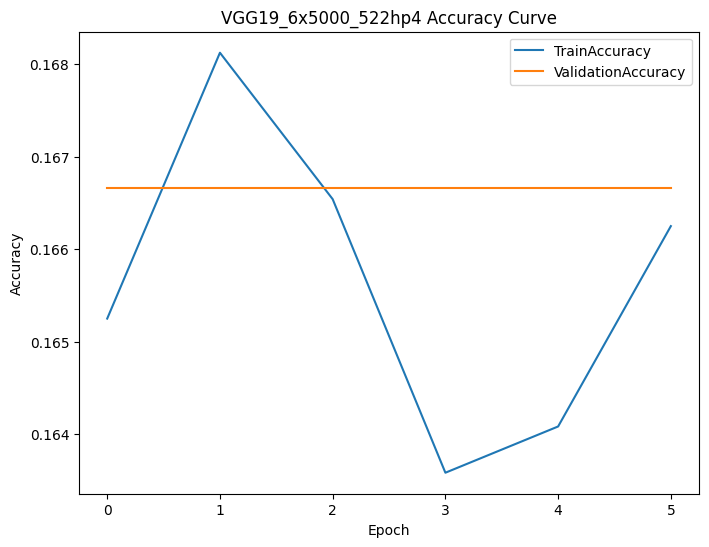

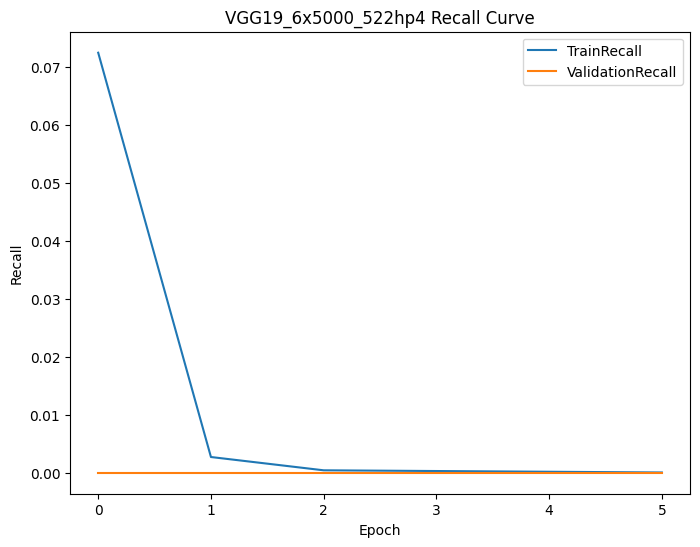

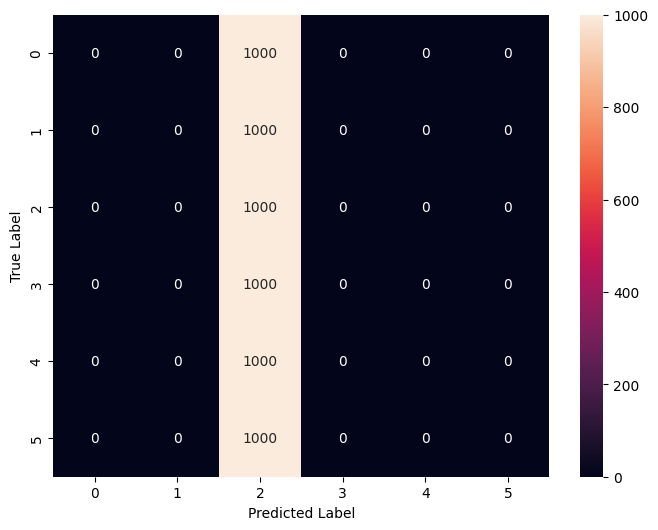

188/188 [==============================] - 5s 27ms/step - loss: 1.7929 - accuracy: 0.1667 - recall: 0.0000e+00
Class=0|TP=0, FP=0, FN=1000, TN=5000
Class=1|TP=0, FP=0, FN=1000, TN=5000
Class=2|TP=1000, FP=5000, FN=0, TN=0
Class=3|TP=0, FP=0, FN=1000, TN=5000
Class=4|TP=0, FP=0, FN=1000, TN=5000
Class=5|TP=0, FP=0, FN=1000, TN=5000
Metric evaluation for VGG19_6x5000_522hp4>> 
{'VGG19_6x5000_522hp4': {'loss': 1.7929, 'accuracy': 0.1667, '0_Precision': nan, '0_Recall': 0.0, '0_F1_Score': nan, '0_Specificity': 1.0, '0_Accuracy': 0.8333333333333334, '1_Precision': nan, '1_Recall': 0.0, '1_F1_Score': nan, '1_Specificity': 1.0, '1_Accuracy': 0.8333333333333334, '2_Precision': 0.16666666666666666, '2_Recall': 1.0, '2_F1_Score': 0.2857142857142857, '2_Specificity': 0.0, '2_Accuracy': 0.16666666666666666, '3_Precision': nan, '3_Recall': 0.0, '3_F1_Score': nan, '3_Specificity': 1.0, '3_Accuracy': 0.8333333333333334, '4_Precision': nan, '4_Recall': 0.0, '4_F1_Score': nan, '4_Specificity': 1.0, '4_

<ipython-input-26-f089b70da28b>:59: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


In [27]:
param_remarks4 = "VGG19_6x5000_522hp4"

pre_trained_model4 = VGG19(include_top = False,
                                weights="imagenet",
                                input_shape=train_images.shape[1:])
pre_trained_model4.trainable = False

for layer in pre_trained_model4.layers:
    layer.trainable = True

x = pre_trained_model4.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.55)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.55)(x)
predictions = Dense(nClasses, activation='softmax')(x)

model_VGG194 = Model(inputs=pre_trained_model4.input, outputs=predictions)

# preparing the model fit - AdamW optimizer will be used for all model evaluation
opt = keras.optimizers.RMSprop(learning_rate=0.01)
model_VGG194.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='recall')])

# preparing the model fit - initialize the TensorBoard
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"./logs/{timestamp}_{param_remarks4}"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# preparing the model fit - EarlyStopping regularization setup to prevent unnecessary overrun
early_stop = EarlyStopping( monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          mode = 'auto')


history4 = model_VGG194.fit(train_images,
                        train_labels_oh,
                        batch_size=64,
                        epochs=20,
                        verbose=1,
                        validation_data=(test_images, test_labels_oh),
                        callbacks=[tensorboard_callback, early_stop])

eval_model(model_VGG194, param_remarks4, test_images, test_labels, test_labels_oh, history4, evaluate_result, nClasses)

parameter tuning hp4 outcome: Had attempted learning rate 0.0001, 0.001 and 0.01, but all resulted in similar where the validation loss, accuracy and recall are horizontal line from the onset epoch, and was therefore early-stopped in the end of epoch5. RMSprop will therefore not be considered.

Parameter tuning hp5: Similar to hp4, optimizer SGD will be used.

Epoch 1/20
375/375 [==============================] - 71s 153ms/step - loss: 1.9025 - accuracy: 0.1845 - recall: 0.0062 - val_loss: 1.7364 - val_accuracy: 0.2895 - val_recall: 0.0000e+00
Epoch 2/20
375/375 [==============================] - 50s 133ms/step - loss: 1.7527 - accuracy: 0.2383 - recall: 1.2500e-04 - val_loss: 1.6696 - val_accuracy: 0.3210 - val_recall: 0.0000e+00
Epoch 3/20
375/375 [==============================] - 50s 132ms/step - loss: 1.6775 - accuracy: 0.2916 - recall: 0.0051 - val_loss: 1.5769 - val_accuracy: 0.3475 - val_recall: 0.0000e+00
Epoch 4/20
375/375 [==============================] - 50s 132ms/step - loss: 1.5984 - accuracy: 0.3250 - recall: 0.0415 - val_loss: 1.4892 - val_accuracy: 0.3738 - val_recall: 0.1192
Epoch 5/20
375/375 [==============================] - 50s 133ms/step - loss: 1.5429 - accuracy: 0.3422 - recall: 0.0872 - val_loss: 1.4366 - val_accuracy: 0.3803 - val_recall: 0.1517
Epoch 6/20
375/375 [==============================] - 50s 133ms/step 

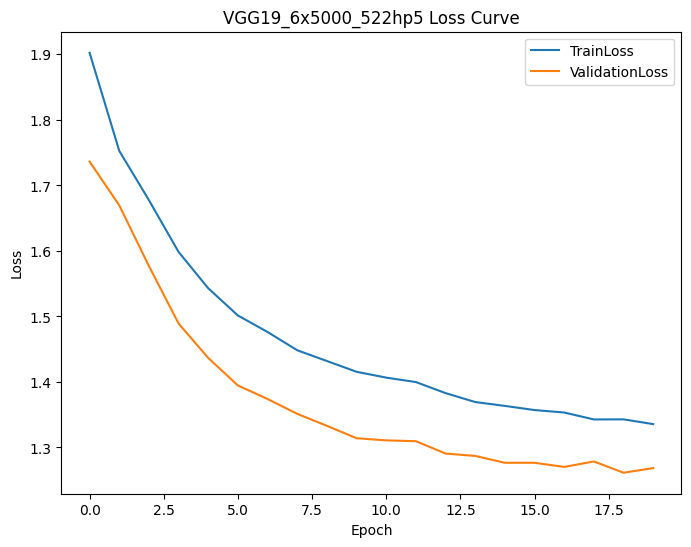

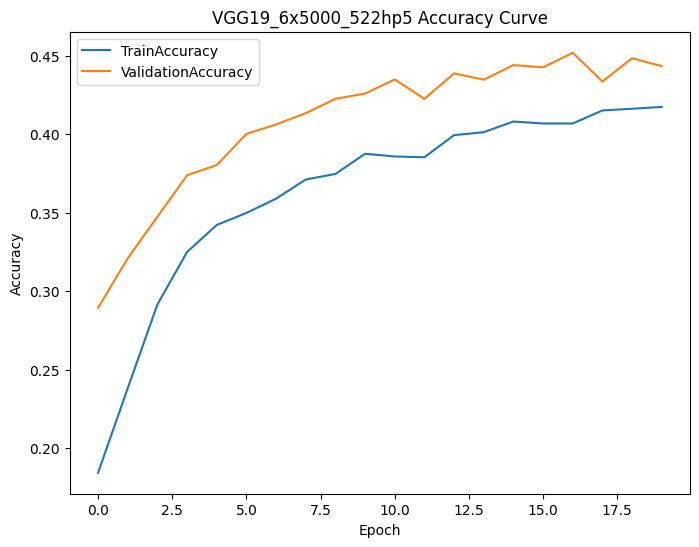

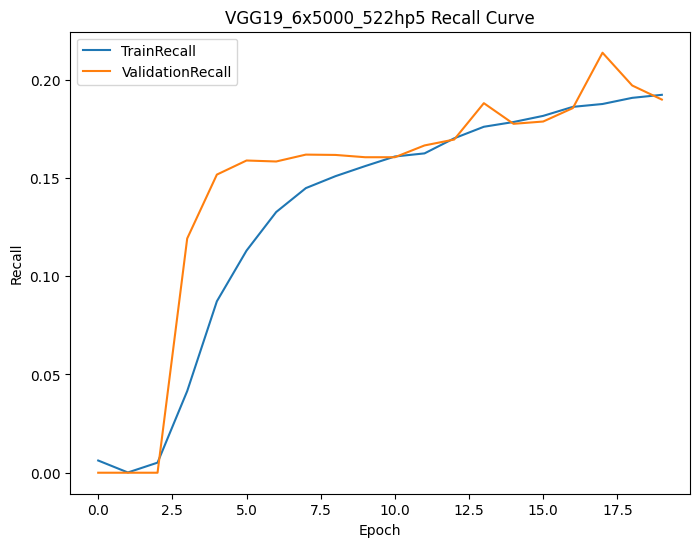

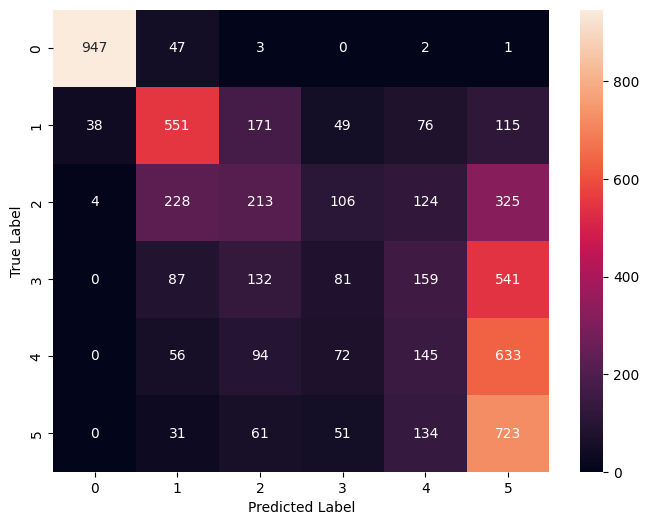

188/188 [==============================] - 5s 27ms/step - loss: 1.2685 - accuracy: 0.4433 - recall: 0.1898
Class=0|TP=947, FP=42, FN=53, TN=4958
Class=1|TP=551, FP=449, FN=449, TN=4551
Class=2|TP=213, FP=461, FN=787, TN=4539
Class=3|TP=81, FP=278, FN=919, TN=4722
Class=4|TP=145, FP=495, FN=855, TN=4505
Class=5|TP=723, FP=1615, FN=277, TN=3385
Metric evaluation for VGG19_6x5000_522hp5>> 
{'VGG19_6x5000_522hp5': {'loss': 1.2685, 'accuracy': 0.4433, '0_Precision': 0.9575328614762386, '0_Recall': 0.947, '0_F1_Score': 0.9522373051784817, '0_Specificity': 0.9916, '0_Accuracy': 0.9841666666666666, '1_Precision': 0.551, '1_Recall': 0.551, '1_F1_Score': 0.551, '1_Specificity': 0.9102, '1_Accuracy': 0.8503333333333334, '2_Precision': 0.31602373887240354, '2_Recall': 0.213, '2_F1_Score': 0.25448028673835127, '2_Specificity': 0.9078, '2_Accuracy': 0.792, '3_Precision': 0.22562674094707522, '3_Recall': 0.081, '3_F1_Score': 0.11920529801324503, '3_Specificity': 0.9444, '3_Accuracy': 0.8005, '4_Preci

In [27]:
param_remarks5 = "VGG19_6x5000_522hp5"

pre_trained_model5 = VGG19(include_top = False,
                                weights="imagenet",
                                input_shape=train_images.shape[1:])
pre_trained_model5.trainable = False

for layer in pre_trained_model5.layers:
    layer.trainable = True

x = pre_trained_model5.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.55)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.55)(x)
predictions = Dense(nClasses, activation='softmax')(x)

model_VGG195 = Model(inputs=pre_trained_model5.input, outputs=predictions)

# preparing the model fit - AdamW optimizer will be used for all model evaluation
opt = keras.optimizers.SGD(learning_rate=0.0001)
model_VGG195.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='recall')])

# preparing the model fit - initialize the TensorBoard
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"./logs/{timestamp}_{param_remarks5}"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# preparing the model fit - EarlyStopping regularization setup to prevent unnecessary overrun
early_stop = EarlyStopping( monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          mode = 'auto')


history5 = model_VGG195.fit(train_images,
                        train_labels_oh,
                        batch_size=64,
                        epochs=20,
                        verbose=1,
                        validation_data=(test_images, test_labels_oh),
                        callbacks=[tensorboard_callback, early_stop])

eval_model(model_VGG195, param_remarks5, test_images, test_labels, test_labels_oh, history5, evaluate_result, nClasses)

parameter tuning hp5 outcome: With SGD (attempted learning rate 0.001 and 0.0001), the overall accuracy and recall did not perform better than AdamW optimizer. Also, the model is overwhelmingly bias in the prediction towards Qty 5, resulting in the very high concentration of False Positive for predicted label 5. 


> Summary: Parameter tuning hp3 resulted in the better improvement in accuracy. Comparing to the parameters used in model evaluation, the overall accuracy improved from 0.4513 to 0.5340. While there was no measured of overall recall during model evaluation, the recall for individual label see improvement:


|label|Model Evaluation|Parameter tuning hp3 outcome|
|---|---|---|
|label 0:| 0.975| 0.98|
|label 1:| 0.636| 0.694|
|label 2:| 0.309| 0.536|
|label 3:| 0.242| 0.319|
|label 4:| 0.231| 0.351|
|label 5:| 0.315| 0.324|



VGG19 -These are the final parameter
1. optimize = AdamW
2. learning rate = 0.00001
3. Batch Size= 64
4. Top level Dense layer having 2 layers (Dense 512 and Dense 512)
5. All layers in VGG19 pretrained model are set to trainable
